# VAE

In [1]:
# import libraries

import torch
import torch.nn as nn

from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# download datasets

# you can also try transforms.ToTensor() + transforms.Normalize(mean, std) with mean = 0.5, std = 0.5, BUT if you do so, instead of nn.Sigmoid() in the model use nn.Tanh()
transform = transforms.ToTensor()

# download data for training
mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True, transform = transform)

# set dataloader
data_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)
# download data for test
test_data = datasets.MNIST(root='./data', train=False,
                            download=True, transform = transform)

100%|██████████| 9912422/9912422 [00:01<00:00, 9563902.97it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2639696.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2021155.66it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9180977.72it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Task 2. Complete VAE architecture

Remember to decrease the dimentionality in encoder, but leave some dimentionalities to reduce while getting mu and sigma, increase in decoder.

mu and sigma can be get by common Linear layers

reparametrization is:

$\mu_x + \sigma_x * \epsilon$

$\sigma_x$ - must be non-negative(can be achieved with exp)

 $\epsilon$ - sampled by normal distribution, size the same as $\sigma_x$

Use Sigmoid() or Tanh() activation func in the end of decoder. (depends on the transformations you applied )

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),    # size of MNIST images
            nn.ReLU(),                  # activation (sigmoid)
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 12)            # 784 -> 12
        )

        self._mu = nn.Linear(12, 3)
        self._sig = nn.Linear(12, 3)

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),           # size of MNIST images
            nn.ReLU(),                  # activation (so all layers are not just linear)
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),      # 784 -> 3
            nn.Sigmoid()
        )

    def reparametrization(self, mu, sigma):
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        return std * eps + mu

    def forward(self, x):
        encoded = self.encoder(x)

        mu = self._mu(encoded)
        sigma = self._sig(encoded)
        encoded = self.reparametrization(mu, sigma)

        decoded = self.decoder(encoded)
        return decoded, mu, sigma

## Task 3. Complete losses

- loss for autoencoder is just MSE

- loss for VAE is ELBO (MSE + KL divergence in analytical form)

$$\begin{align*}\text{ELBO}(\phi, \theta) &= \sum_{i=1}^n E_{z_i \sim q} \left[ \log p_\theta(\boldsymbol{x}_i, \boldsymbol{z}_i) - \log q( \boldsymbol{z}_i \mid \boldsymbol{x}_i) \right] \\ &= \sum_{i=1}^n \int q(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \left[\log p_\theta(\boldsymbol{x}_i, \boldsymbol{z}_i) - \log q(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \right] \ d\boldsymbol{z}_i \\ &= \sum_{i=1}^n \int q(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \left[\log p_\theta(\boldsymbol{x}_i \mid \boldsymbol{z}_i) + \log p(\boldsymbol{z}_i) - \log q(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \right] \ d\boldsymbol{z}_i \\ &= \sum_{i=1}^n E_{\boldsymbol{z}_i \sim q} \left[ \log p_\theta(\boldsymbol{x}_i \mid \boldsymbol{z}_i) \right] + \sum_{i=1}^n \int q(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \left[\log p(\boldsymbol{z}_i) - \log q(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \right] \ d\boldsymbol{z}_i \\ &= \sum_{i=1}^n E_{\boldsymbol{z}_i \sim q} \left[ \log p_\theta(\boldsymbol{x}_i \mid \boldsymbol{z}_i) \right] + \sum_{i=1}^n E_{\boldsymbol{z}_i \sim q}\left[ \log \frac{ p(\boldsymbol{z}_i)}{q(\boldsymbol{z}_i \mid \boldsymbol{x}_i)} \right] \\ &= \sum_{i=1}^n E_{\boldsymbol{z}_i \sim q} \left[ \log p_\theta(\boldsymbol{x}_i \mid \boldsymbol{z}_i) \right] - KL(q(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \ || \ p(\boldsymbol{z}_i)) \end{align*}$$


Likelihood can be expressed as:
$$\sum_{i=1}^n E_{\boldsymbol{z}_i \sim q} \left[ \log p_\theta(\boldsymbol{x}_i \mid \boldsymbol{z}_i) \right] \sim MSE(z_i, x_i)$$

Here KL can be analytically expressed as:
$$
KL(q_\phi(\boldsymbol{z}_i \mid \boldsymbol{x}_i) \mid\mid p(\boldsymbol{z}_i)) = -\frac{1}{2} \sum_{j=1}^J \left(1 + \sigma_\phi(\boldsymbol{x}_i)_j - \left(\mu_\phi(\boldsymbol{x}_i)\right)_j^2 - \exp(\sigma_\phi(\boldsymbol{x}_i)_j) \right)$$

In [6]:
# loss function for AE
loss_func_ae = nn.MSELoss()

# loss function for VAE
def loss_func_vae(recon, x, mu, sigma):
  LLH = torch.nn.functional.mse_loss(recon, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

  return LLH + KLD

# TRAIN AND TEST VAE

In [9]:
# TRAIN the VAE model

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10  # try more!

for epoch in range(num_epochs):
  for (img,_) in data_loader:
    img = img.reshape(-1, 28*28)

    recon, mu, sigma = model(img)

    loss = loss_func_vae(recon, img, mu, sigma)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
  print(f'Epoch{epoch+1}, Loss:{loss.item():.4f}')

Epoch1, Loss:1425.8719
Epoch2, Loss:1351.4921
Epoch3, Loss:1240.8845
Epoch4, Loss:1232.2811
Epoch5, Loss:1321.9778
Epoch6, Loss:1164.4010
Epoch7, Loss:1201.6307
Epoch8, Loss:1289.8652
Epoch9, Loss:1053.9794
Epoch10, Loss:1206.8297


torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 28, 28])
torch.Size([1, 784])


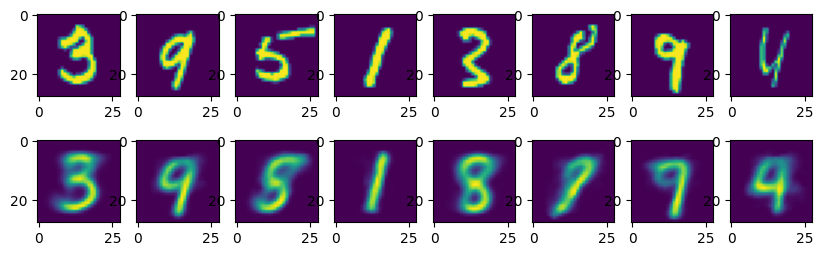

In [14]:
model.eval()

Orig, Recov = [], []

for i in range(8):
  idx = np.random.randint(len(test_data))
  # Orig.append(test_data[idx][0])
  print(test_data[idx][0].shape)
  # print(Orig[i].reshape(-1, 28 * 28).shape)
  Recov.append(model(Orig[i].reshape(-1, 28 * 28)))

fig, ax = plt.subplots(nrows=2, ncols =8, figsize=(10,3))

for i in range(8):
  ax[0,i].imshow(Orig[i].squeeze())
  ax[1,i].imshow(Recov[i][0].detach().reshape(28,28))

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


